In [1]:
import pylab as plt
import numpy as np
from scipy.signal import detrend,welch
import scipy.signal as sg
from  lib_filters_obp import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.constants as consts

mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

shape: (1000,)
shape: (1000,) (1000,)
Nb of points OBP kernel: 41
Nb of points OBP kernel: 241


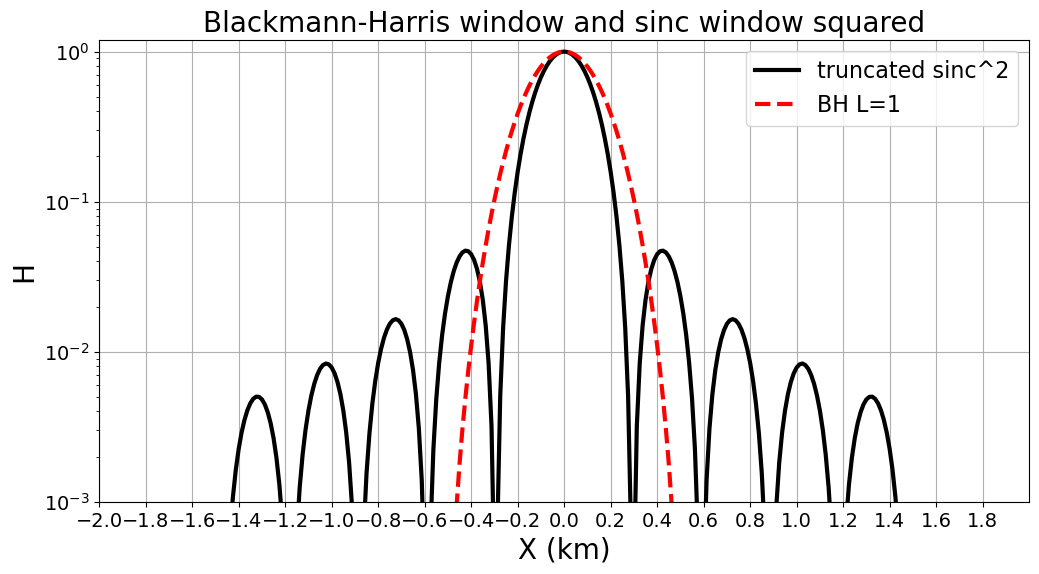

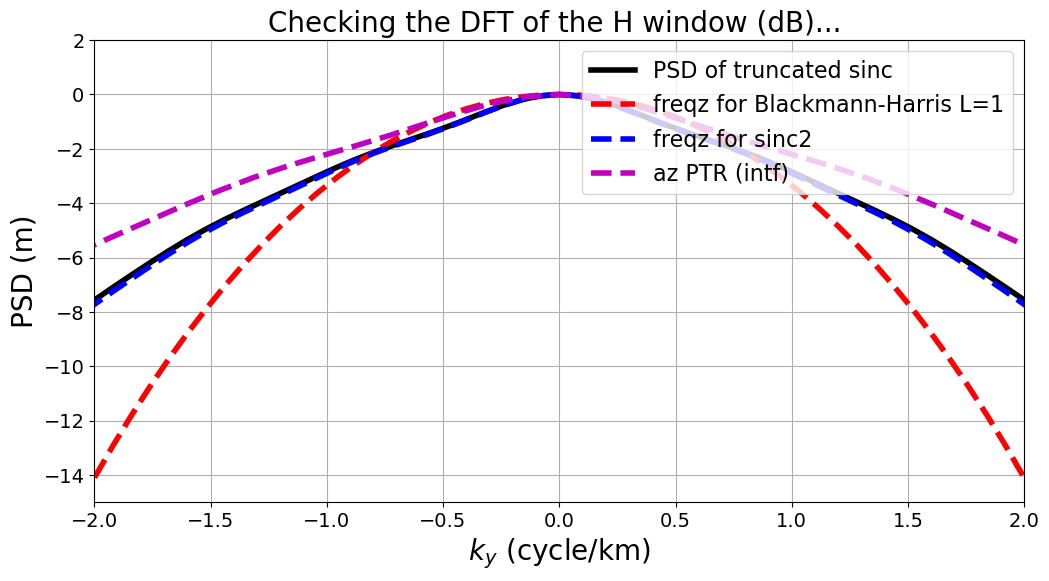

In [2]:
# Now we check for the DFT of G^2 in the case of a Blackmann-Harris and a truncated sinc window

nx=1000
dx=0.0125 # in km

Xa = np.arange(0,nx*dx,dx)
Xc=Xa[nx//2]
Lx=1
print('shape:',np.shape(Xa))
      
Lt=np.max(Xa)-np.min(Xa)  # Lt is the actual length over which the FFT is taken along x
#
# Defines the Blackmann-Harris window
#https://ccrma.stanford.edu/~jos/sasp/Three_Term_Blackman_Harris_Window.html
a0=0.4243801;a1=0.4973406;a2=0.0782793;a3=0;
a0=0.35875;a1=0.48829;a2=0.14128;a3=0.01168; # this is from scipy code 
xn=(Xa-Xc)*2*np.pi/Lx
ind = np.where(abs(xn)*0.54/5 <= 1)[0]
indbh = np.where(abs(xn) <= np.pi)[0]
ind123= np.where(abs(xn/1.1) <= np.pi)[0]
window=np.zeros(nx)
winobp=np.zeros(nx)
winobl=np.zeros(nx)
window[ind]=(np.sinc(xn[ind]*0.54)) 
winobp[indbh]=sg.blackmanharris(len(indbh))
winobl[ind123]=sg.blackmanharris(len(ind123))

windowWelch=np.ones(nx)


print('shape:',np.shape(Xa),np.shape(window))

wsum=np.sum(window)
#window=window/wsum
wsum2=np.sum(winobp)
#winobp=winobp/wsum2


fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('Blackmann-Harris window and sinc window squared', fontsize=20)
_=ax.set_xlabel('X (km)', fontsize=20)
_=ax.set_ylabel('H' , fontsize=20)
line1=ax.plot(Xa-Xc,window**2,linewidth=3,color='k',label='truncated sinc^2')
line2=ax.plot(Xa-Xc,winobp,linewidth=3,color='r',ls='dashed',label='BH L=1')
#line2=ax.plot(Xa-Xc,winobl**2,linewidth=3,color='b',ls='dashed',label='BH^2 L=1.23')
ax.set_xlim([-2,2]);
ax.set_ylim([0.001,1.2]);
ax.set_xticks(np.arange(-2,2,0.2))
leg = ax.legend(loc='upper right', fontsize=16)
ax.set_yscale('log')
nfftx=512

kxs= np.fft.fftshift(np.fft.fftfreq(nx, dx)) 
dkx=kxs[1]-kxs[0]
# compute PSD... . 
zspec=np.fft.fftshift((np.abs( np.fft.fft(window**2)/nfftx  )**2) /dkx )
znorm=zspec/np.nanmax(zspec)

#f_obp, S_obp = sg.freqz(window, fs=4)
x_at, w_at, f_obp, S_obp = get_obp_filter(L_filt = 1, f_axis = kxs, plot_flag = False, kernel="bharris")
#x_at, w_at, f_obp, S_ptr = get_obp_filter(L_filt = 1.23, f_axis = kxs, plot_flag = False, kernel="bharris")
x_at, w_at, f_obp, S_ptr = get_obp_filter(L_filt = 3, sampling_in = 0.0125,f_axis = kxs, plot_flag = False, kernel="sinc2")

# Pieces from Alejandro: first simple version without replica and antenna pattern
PRF = 4332
N_burst = 9
v_sat = 7310.
H = 875.0e3
incidence_deg = 3.5 # just used for the ground/range conversion for xtrack

f_s = 300.0e6
v_ground = v_sat/(1+H/6377.0e3)
lambda_c = (consts.c/35.75e9)

d = N_burst*v_ground/PRF # along track posting before OBP averaging


w_ptr = np.zeros(512)
#w_ptr[:71] = np.sinc(2*v_sat*N_burst/(lambda_c*H*PRF)*np.arange(-35,36)*d)**2
w_ptr[:141] = np.sinc(2*v_sat*N_burst/(lambda_c*H*PRF)*np.arange(-70,71)*d)**2
w_ptr /= np.sum(w_ptr)*d



fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('Checking the DFT of the H window (dB)... ', fontsize=20)
_=ax.set_xlabel('$k_y$ (cycle/km)', fontsize=20)
_=ax.set_ylabel('PSD (m)' , fontsize=20)

 
# defines number of wavenumbers for plot 
np1=100
#line1=ax.plot(kxs,10*np.log10(znorm),linewidth=4,color='k',label='my own PSD')
#line3=ax.plot(kxs,10*np.log10(conv**2),linewidth=3,color=[1,0.5,0.5],linestyle='dashed',label=r'H^2')
#_=ax.set_ylim((-120,0))
line1=ax.plot(kxs,10*np.log10(znorm),linewidth=4,color='k',label='PSD of truncated sinc')
#line3=ax.plot(kxs,(conv**2),linewidth=3,color=[1,0.5,0.5],linestyle='dashed',label=r'H^2')
#line3=ax.plot(kxs,(conv),linewidth=3,color=[1,0.5,0.5],linestyle='dashed',label=r'H')
line1=ax.plot(f_obp,10*np.log10(S_obp),linewidth=4,color='r',label='freqz for Blackmann-Harris L=1',linestyle='dashed')
line1=ax.plot(f_obp,10*np.log10(S_ptr),linewidth=4,color='b',label='freqz for sinc2',linestyle='dashed')
line_al=ax.plot(1000*np.fft.fftshift(np.fft.fftfreq(len(w_ptr), d=d)),10*np.log10( np.fft.fftshift(np.abs(d*np.fft.fft(w_ptr))**2)),linewidth=4,color='m',linestyle='dashed', label='az PTR (intf)')

leg = ax.legend(loc='upper right', fontsize=16)
ax.set_ylim([-15.0,2]);
ax.set_xlim([-2.0,2.0]);



In [3]:
def G_field_oneway(theta):
    # This antenna pattern function was fitted on measured antenna patterns by Alejandro Bohe (hence the "strange" 2.25 power)
    # this is for the field (hence the sqrt, because the fit was on the "power") . This was corrected on 2024/05/26 
    return np.sqrt(np.exp(-np.abs(theta/(np.radians(.107)/2))**2.25*np.log(2)))


<xarray.Dataset>
Dimensions:       (time: 388, tau: 40)
Coordinates:
  * time          (time) float64 0.000905 0.002941 0.004977 ... 0.7869 0.7889
    transmitter   object ...
    polarization  object ...
  * tau           (tau) float64 0.006045 0.006045 0.006045 ... 0.006045 0.006045
    receiver      object ...
    beam          int64 ...
Data variables:
    PTR_real      (time, tau) float64 ...
    PTR_imag      (time, tau) float64 ...
nr,na 40 388


/home/ardhuin/anaconda3/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


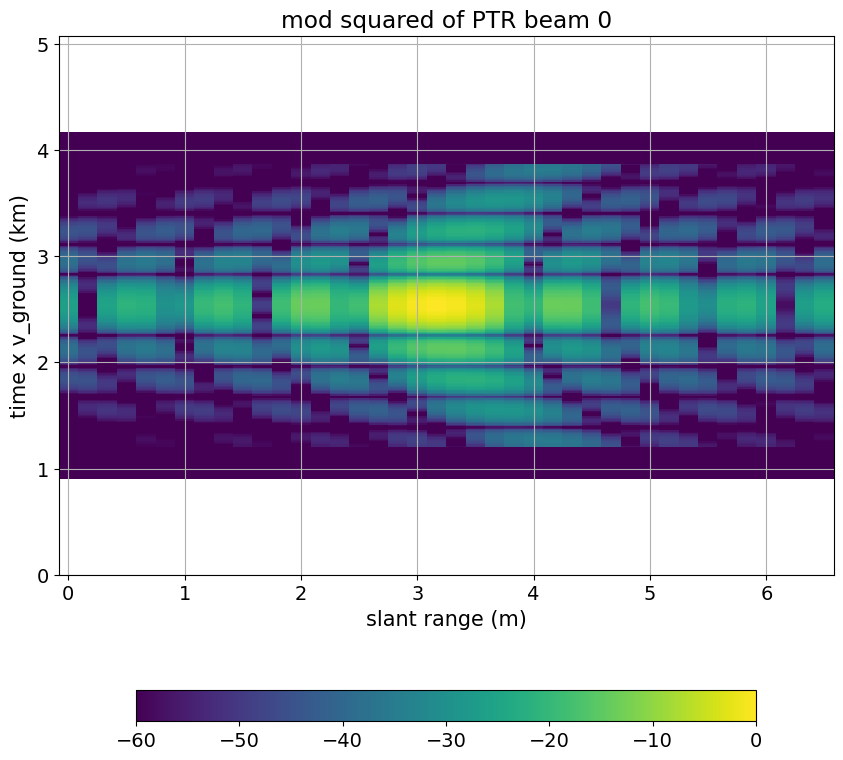

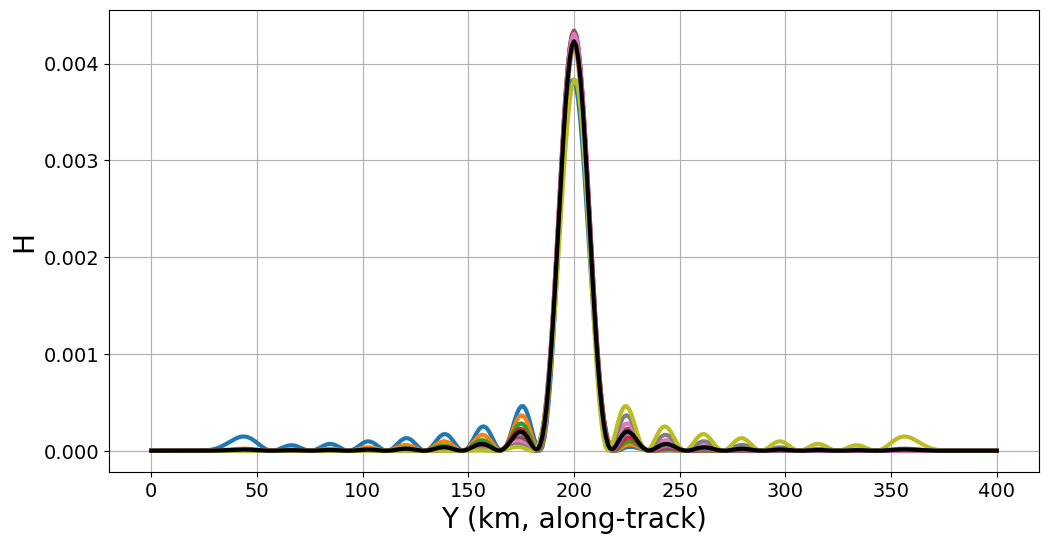

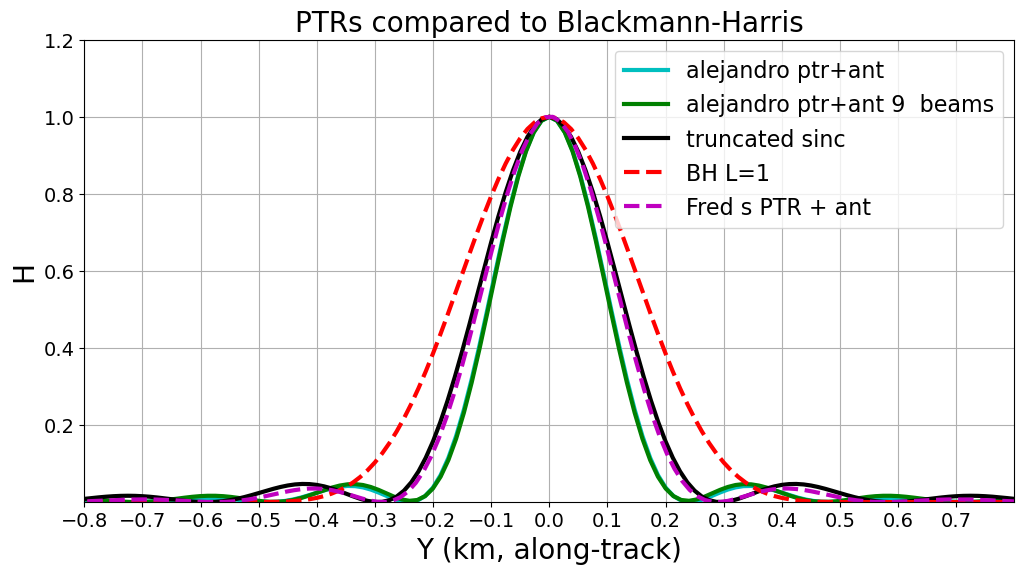

In [4]:
import xarray as xr
ds= xr.open_dataset('SWOT_beam0.nc')
print(ds)
#* tau : (fast time == range). Donc sr = celerity*tau/2 est le slant_range. A projeter ensuite en ground_range en fonction de là où tu es dans la fauchée mais bon, cela ne devrait avoir aucun impact pour toi. (Attention il faut prendre une valeur de la celerité bien précise! j'utilise celle de scipy.constants)
#* time (slow time == azimuth). A convertir en mètres avec la vitesse du satellite que je t'ai mis dans les attributs du netcdf
#Je t'ai laissé en complexe, comme ça tu sauras où mettre les carrés qui vont bien ! Un petit plot en [mètre,mètre] peut être pas mal pour vérifier que le lobe est bien d'environ 300 m en azimuth et autour des 10 m en ground_range en milieu de fauchée (~2 degrés)

ptrmod2=(ds.PTR_real**2+ds.PTR_imag**2)
ptmax=np.max(ptrmod2)
celerity=299792458
sr = celerity*ds.tau/2  # slant range
sr0=np.min(sr)
[na,nr]=np.shape(ptrmod2)
print('nr,na',nr,na)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
im=ax.pcolormesh(sr-sr0,ds.time*v_ground/1000,10*np.log10(ptrmod2/ptmax),cmap='viridis',rasterized=True,vmin=-60, vmax=0)
_=plt.colorbar(im,ax=ax,label='', location='bottom',shrink=0.8)
_=ax.set_title('mod squared of PTR beam 0')
 #plt.setp(axs[1].get_yticklabels(), visible=False)
_=ax.set_ylabel('time x v_ground (km)', fontsize=15)
_=ax.set_xlabel('slant range (m)' , fontsize=15)
fig.savefig('Freds_PTR.png',dpi=100)  
    
plt.show()

ptrm=ptrmod2[:,nr//2-1]/ptmax
ptrm=np.sum(ptrmod2[:,:],axis=1)
ptmax1=max(ptrm)
ptrm=ptrm/ptmax1


# ALE's stuff 
PRF = 4332
N_burst = 9
v_sat = 7310.
H = 875.0e3
f_s = 300.0e6
v_ground = v_sat/(1+H/6377.0e3)
lambda_c = (consts.c/35.75e9)
incidence_deg = 3.5 # just used for the ground/range conversion for xtrack
d = N_burst*v_ground/PRF # along track posting before OBP averaging
w_ptr = np.zeros(512)
w_ptr[:401] = np.sinc(2*v_sat*N_burst/(lambda_c*H*PRF)*np.arange(-200,201)*d)**2
w_ptr /= np.sum(w_ptr)*d
w_ale = np.zeros(512)
y_tab = np.arange(-200,201)*d+1.0e-3
ant = G_field_oneway(y_tab/H)**4
w_ale[:len(y_tab)] = np.sin(2*np.pi*v_sat*N_burst/(lambda_c*H*PRF)*y_tab)**2/np.sin(2*np.pi*v_sat/(lambda_c*H*PRF)*y_tab)**2*ant
w_ale /= np.max(w_ale)

# now for the 9 beams 
w_ale9 = np.zeros(512)
w_ptrantana_b = np.zeros((9,512))
w_ptrantana_c = np.zeros((9,512))
b_vals = np.arange(-4,5)
arg_b = 0.8/N_burst*b_vals[:,None]+2*v_sat/(lambda_c*H*PRF)*y_tab[None,:]
w_ptrantana_b[:,:len(y_tab)] = np.sin(np.pi*N_burst*arg_b)**2/np.sin(np.pi*arg_b)**2*(G_field_oneway(y_tab/H)**4)[None,:]
w_ptrantana_b = w_ptrantana_b/(np.sum(w_ptrantana_b, axis=1)[:,None]*d)
# these weights actually vary along the track. This is one set of weights obtained by averaging along one (?) cycle
weights = np.array([0.07019711, 0.09767803, 0.12220272, 0.13814296, 0.14355835,0.13814296, 0.12220272, 0.09767803, 0.07019711])
#weights = np.array([0.0 , 0.0 , 0. , 0. , 0.14355835,0. , 0., 0.0 , 0.0 ])
#w2=np.tile(weights,(512,1)).T
for ib in range(9) :
    w_ale9=w_ale9+weights[ib]*np.roll(w_ptrantana_b[ib,:],14*(ib-4))
    w_ptrantana_c[ib,:] = np.roll(w_ptrantana_b[ib,:],14*(ib-4))
fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_xlabel('Y (km, along-track)', fontsize=20)
_=ax.set_ylabel('H' , fontsize=20)
line1=ax.plot( w_ptrantana_c[:,:len(y_tab)].T ,linewidth=3)
line1=ax.plot(w_ale9[:len(y_tab)] ,c='k',linewidth=3)


w_ale9 /= np.max(w_ale9)

ant_fred=G_field_oneway((ds.time-0.395)*v_ground/H)**4
    
fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('PTRs compared to Blackmann-Harris', fontsize=20)
_=ax.set_xlabel('Y (km, along-track)', fontsize=20)
_=ax.set_ylabel('H' , fontsize=20)
line1=ax.plot(y_tab*0.001, w_ale[:len(y_tab)],linewidth=3,color='c',label='alejandro ptr+ant')
line1=ax.plot(y_tab*0.001, w_ale9[:len(y_tab)],linewidth=3,color='g',label='alejandro ptr+ant 9  beams')
line1=ax.plot(Xa-Xc,window**2,linewidth=3,color='k',label='truncated sinc')
line2=ax.plot(Xa-Xc,winobp,linewidth=3,color='r',ls='dashed',label='BH L=1')
line2=ax.plot((ds.time-0.395)*v_ground/1000.,ptrm,linewidth=3,color='m',ls='dashed',label='Fred s PTR + ant')

ax.set_xlim([-0.8,0.8]);
ax.set_ylim([0.001,1.2]);
ax.set_xticks(np.arange(-0.8,0.8,0.1))
leg = ax.legend(loc='upper right', fontsize=16)
fig.savefig('comparing_PTRs.png',dpi=100)  


TEST: 0.013141628959276015 388 0.013073888603815833
Nb of points OBP kernel: 41
Nb of points OBP kernel: 41
(1000,) 0.9999999999999984
(1000,) 0.9999999800000007


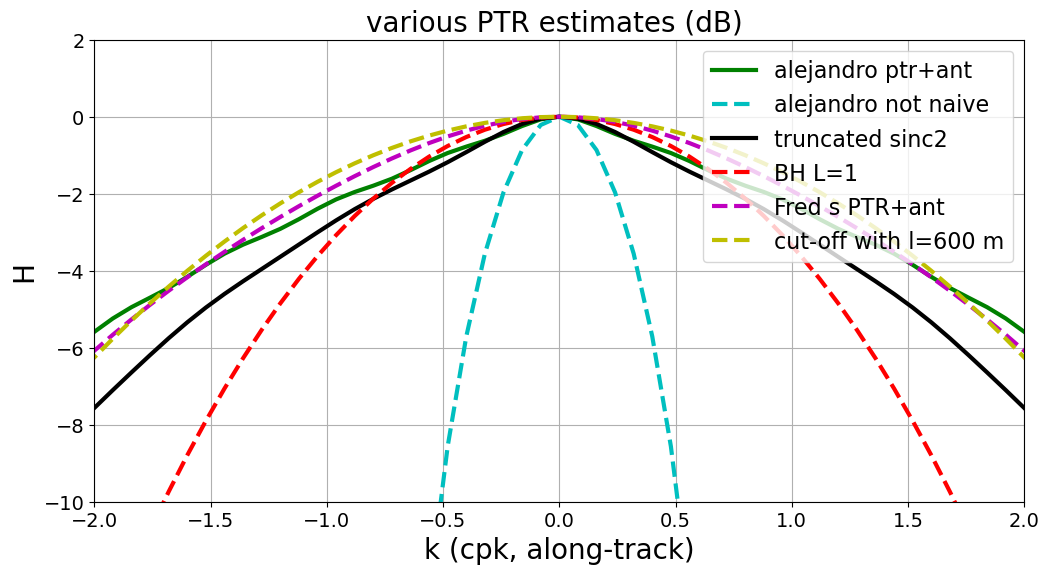

In [5]:


time=ds.time.values
dxfred=(time[1]-time[0])*v_ground/1000
print('TEST:',(time[1]-time[0])*6.454,len(time),(time[-1]-time[1])*6.454/len(time))

x_at, w_at, f_obp, H_ptr = get_obp_filter(L_filt = 1,f_axis = kxs, plot_flag = False, kernel="alejandro_azptr")
#x_at, w_at, f_obp, H_ptr = get_obp_filter(L_filt = 1,f_axis = kxs, plot_flag = False, kernel="alejandro_azptr_beam0")
x_at, w_at, f_obp, H_ptr9 = get_obp_filter9(L_filt = 1,f_axis = kxs, plot_flag = False, kernel="alejandro_azptr")
print(np.shape(H_ptr),np.max(H_ptr))
print(np.shape(H_ptr9),np.max(H_ptr9))

fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('various PTR estimates (dB) ', fontsize=20)
_=ax.set_xlabel('k (cpk, along-track)', fontsize=20)
_=ax.set_ylabel('H' , fontsize=20)
line1=ax.plot(f_obp, 10*np.log10(H_ptr),linewidth=3,color='g',label='alejandro ptr+ant')
line1=ax.plot(f_obp, 10*np.log10(H_ptr9),linewidth=3,color='c',ls='dashed',label='alejandro not naive')
w_obp=window**2
w_obp /= np.sum(w_obp)
f_obp, S_obp = sg.freqz(w_obp, fs=1/(Xa[1]-Xa[0]), worN=kxs)
S_obp = np.abs(S_obp)**2
line1=ax.plot(f_obp, 10*np.log10(S_obp),linewidth=3,color='k',label='truncated sinc2')
w_obp=winobp
w_obp /= np.sum(w_obp)
f_obp, S_obp = sg.freqz(w_obp, fs=1/(Xa[1]-Xa[0]), worN=kxs)
S_obp = np.abs(S_obp)**2
line2=ax.plot(f_obp, 10*np.log10(S_obp),linewidth=3,color='r',ls='dashed',label='BH L=1')



        
w_obp=ptrm*ant_fred
w_obp /= np.sum(w_obp)
f_obp, S_obp = sg.freqz(w_obp, fs=1/(Xa[1]-Xa[0]), worN=kxs)
S_obp = np.abs(S_obp)**2
line2=ax.plot(f_obp, 10*np.log10(S_obp),linewidth=3,color='m',ls='dashed',label='Fred s PTR+ant')
line3=ax.plot(f_obp, 10*np.log10(np.exp(-(f_obp*0.6)**2)),linewidth=3,color='y',ls='dashed',label='cut-off with l=600 m')


ax.set_ylim([-10.0,2]);
ax.set_xlim([-2.0,2.0]);
leg = ax.legend(loc='upper right', fontsize=16)
fig.savefig('comparing_PTR_PSDs.png',dpi=100)  

<xarray.Dataset>
Dimensions:       (time: 388, tau: 150, beam: 9)
Coordinates:
  * time          (time) float64 0.000905 0.002941 0.004977 ... 0.7869 0.7889
    transmitter   object ...
    polarization  object ...
  * tau           (tau) float64 0.005838 0.005838 0.005838 ... 0.005838 0.005838
    receiver      object ...
  * beam          (beam) int64 -4 -3 -2 -1 0 1 2 3 4
    azimuth       (time) float64 ...
Data variables:
    PTR_real      (time, beam, tau) float64 ...
    PTR_imag      (time, beam, tau) float64 ...
Attributes:
    sat_ground_velocity:  6428.0
nb,nr,na 9 150 388


/home/ardhuin/anaconda3/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


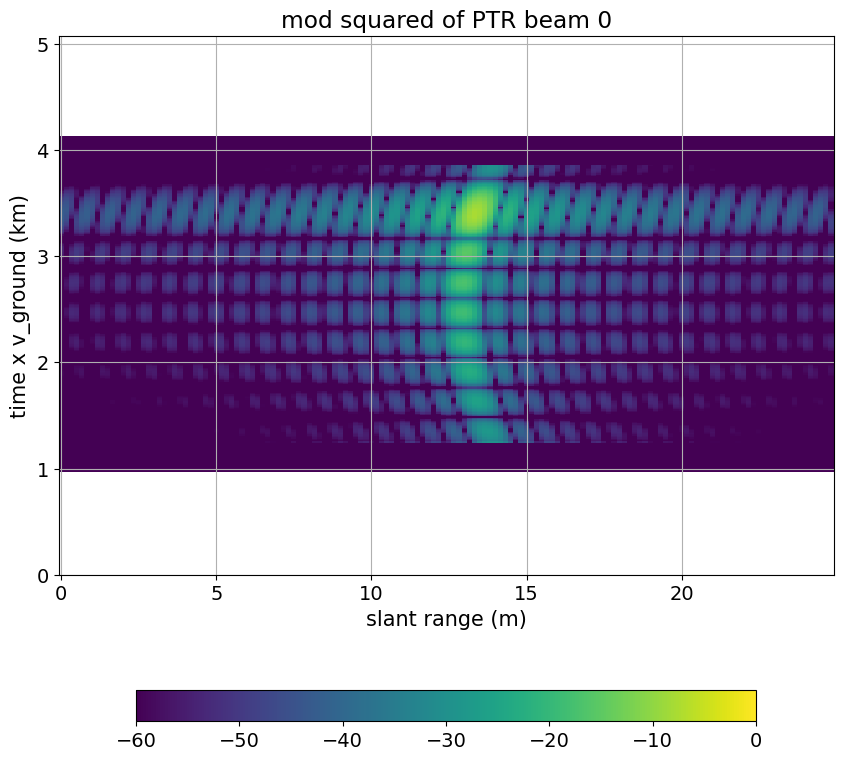

TEST: (388, 9) 13.088691713691714 14.89835686144368


/tmp/ipykernel_28020/2402797548.py:51: RuntimeWarning: divide by zero encountered in log10
  line2=ax.plot((ds.time-0.395)*v_ground/1000.,10*np.log10(ws[ib]*np.roll(ptrmi,dd*(ib-4))),linewidth=3,alpha=0.5,color=colors[ib],label='Fred s PTR + ant, beam '+f'{abs(ib):1d}')
/tmp/ipykernel_28020/2402797548.py:51: RuntimeWarning: divide by zero encountered in log10
  line2=ax.plot((ds.time-0.395)*v_ground/1000.,10*np.log10(ws[ib]*np.roll(ptrmi,dd*(ib-4))),linewidth=3,alpha=0.5,color=colors[ib],label='Fred s PTR + ant, beam '+f'{abs(ib):1d}')
/tmp/ipykernel_28020/2402797548.py:51: RuntimeWarning: divide by zero encountered in log10
  line2=ax.plot((ds.time-0.395)*v_ground/1000.,10*np.log10(ws[ib]*np.roll(ptrmi,dd*(ib-4))),linewidth=3,alpha=0.5,color=colors[ib],label='Fred s PTR + ant, beam '+f'{abs(ib):1d}')
/tmp/ipykernel_28020/2402797548.py:51: RuntimeWarning: divide by zero encountered in log10
  line2=ax.plot((ds.time-0.395)*v_ground/1000.,10*np.log10(ws[ib]*np.roll(ptrmi,dd*(ib-4))),line

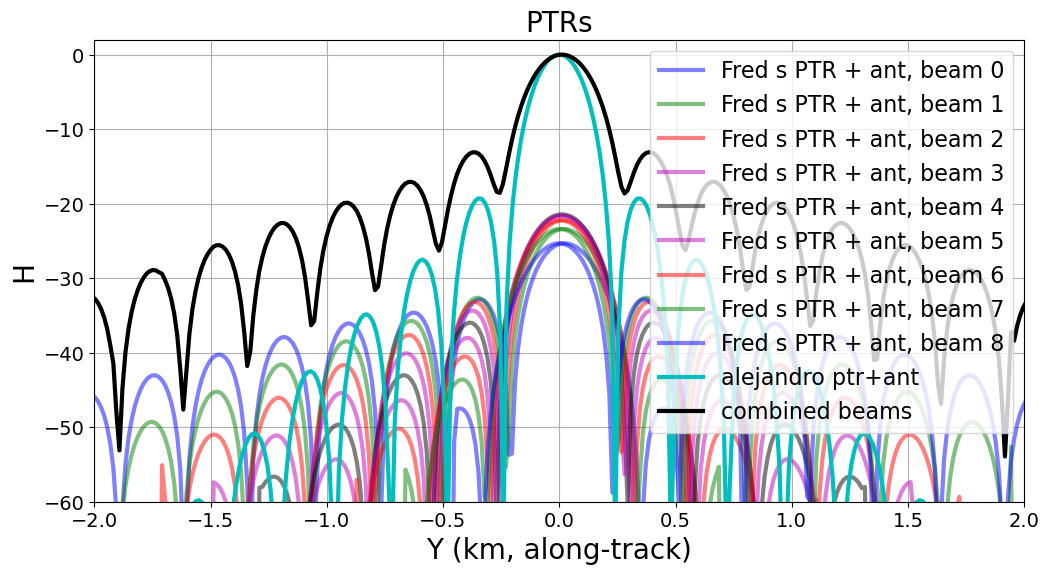

In [27]:
import xarray as xr
ds= xr.open_dataset('SWOT_PTRs.nc')
print(ds)
ground_v = 6428.
ptrmod2=(ds.PTR_real**2+ds.PTR_imag**2)
ptmax=np.max(ptrmod2)
celerity=299792458
sr = celerity*ds.tau/2  # slant range
sr0=np.min(sr)
[na,nb,nr]=np.shape(ptrmod2)
print('nb,nr,na',nb,nr,na)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
im=ax.pcolormesh(sr-sr0,ds.time*v_ground/1000,10*np.log10(ptrmod2[:,0,:]/ptmax),cmap='viridis',rasterized=True,vmin=-60, vmax=0)
_=plt.colorbar(im,ax=ax,label='', location='bottom',shrink=0.8)
_=ax.set_title('mod squared of PTR beam 0')
 #plt.setp(axs[1].get_yticklabels(), visible=False)
_=ax.set_ylabel('time x v_ground (km)', fontsize=15)
_=ax.set_xlabel('slant range (m)' , fontsize=15)
fig.savefig('Freds_PTR_beam0.png',dpi=100)  
    
plt.show()

ptrm=np.sum(ptrmod2[:,:,:],axis=2)
#ptmax1=max(ptrm)
dy=(ds.time[1]-ds.time[0]).values*v_ground
print('TEST:',np.shape(ptrm),dy,195/dy)


        
ant_fred=G_field_oneway((ds.time-0.395)*v_ground/H)**4
colors=['b','g','r','m','k','m','r','g', 'b']
ws=np.array([0.07019711, 0.09767803, 0.12220272, 0.13814296, 0.14355835,0.13814296, 0.12220272, 0.09767803, 0.07019711])
fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('PTRs', fontsize=20)
_=ax.set_xlabel('Y (km, along-track)', fontsize=20)
_=ax.set_ylabel('H' , fontsize=20)
#line1=ax.plot(Xa-Xc,window**2,linewidth=3,color='k',label='truncated sinc')
#line2=ax.plot(Xa-Xc,winobp,linewidth=3,color='r',ls='dashed',label='BH L=1')
#line2=ax.plot((ds.time-0.395)*v_ground/1000.,ptrm*ant_fred,linewidth=3,color='m',ls='dashed',label='Fred s PTR + ant')
ptrmm=ptrm[:,0]*0.
dd=16
for ib in range(nb):
    ptrmi=ptrm[:,ib]/np.sum(ptrm[:,ib])
    ptrmi=ptrmi   #*ant_fred/np.max(ptrmi)
    #az1=np.max(0,(ib-4)*dd)
    #az2=np.min(na-1,na-1+(ib-4)*dd)
    #az3=np.max(0,-(ib-4)*dd)
    #az4=np.min(na-1,na-1-(ib-4)*dd)
    ptrmm=ptrmm+ws[ib]*np.roll(ptrmi,dd*(ib-4)) #[az3:az4]=ptrmm[az3:az4]+ptrmi[az1:az2]
#    line2=ax.plot((ds.time-0.395)*v_ground/1000.+0.22*(ib-4),10*np.log10(ptrmi),linewidth=3,alpha=0.5,color=colors[ib],label='Fred s PTR + ant, beam '+f'{abs(ib):1d}')
    line2=ax.plot((ds.time-0.395)*v_ground/1000.,10*np.log10(ws[ib]*np.roll(ptrmi,dd*(ib-4))),linewidth=3,alpha=0.5,color=colors[ib],label='Fred s PTR + ant, beam '+f'{abs(ib):1d}')
line1=ax.plot(y_tab*0.001, 10*np.log10(w_ale[:len(y_tab)]),linewidth=3,color='c',label='alejandro ptr+ant')
line2=ax.plot((ds.time-0.395)*v_ground/1000.,10*np.log10(ptrmm/np.max(ptrmm)),linewidth=3,color='k',label='combined beams')

ax.set_xlim([-2,2]);
ax.set_ylim([-60,2]);
leg = ax.legend(loc='upper right', fontsize=16)
fig.savefig('comparing_PTRs_allbeams_dB.png',dpi=100)  

Nb of points OBP kernel: 41


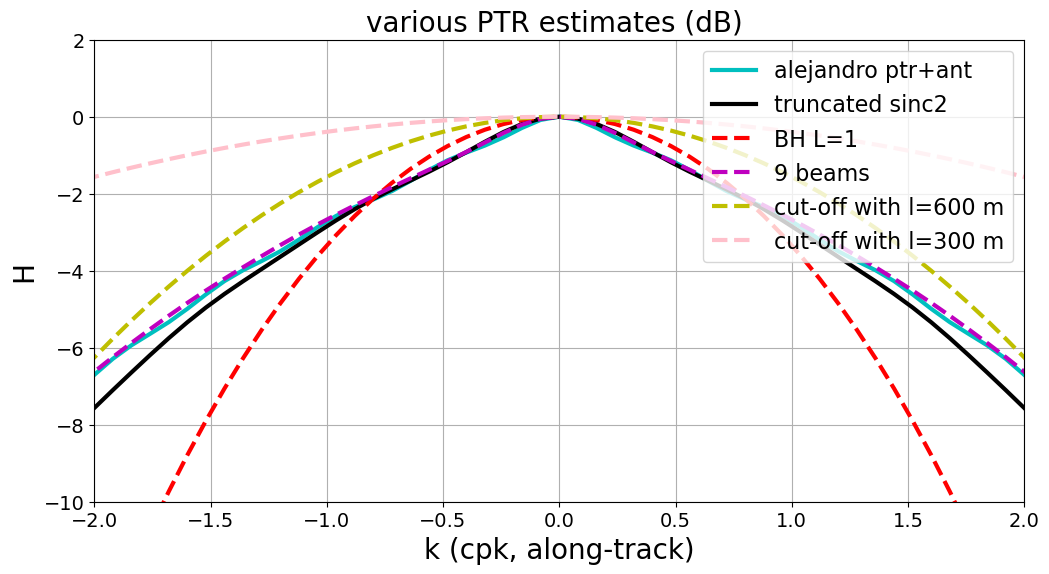

In [28]:

x_at, w_at, f_obp, H_ptr = get_obp_filter(L_filt = 1,f_axis = kxs, plot_flag = False, kernel="alejandro_azptr")

fig,ax=plt.subplots(figsize=(12,6))
_=ax.set_title('various PTR estimates (dB) ', fontsize=20)
_=ax.set_xlabel('k (cpk, along-track)', fontsize=20)
_=ax.set_ylabel('H' , fontsize=20)
line1=ax.plot(f_obp, 10*np.log10(H_ptr**1.2),linewidth=3,color='c',label='alejandro ptr+ant')
w_obp=window**2
w_obp /= np.sum(w_obp)
f_obp, S_obp = sg.freqz(w_obp, fs=1/(Xa[1]-Xa[0]), worN=kxs)
S_obp = np.abs(S_obp)**2
line1=ax.plot(f_obp, 10*np.log10(S_obp),linewidth=3,color='k',label='truncated sinc2')
w_obp=winobp
w_obp /= np.sum(w_obp)
f_obp, S_obp = sg.freqz(w_obp, fs=1/(Xa[1]-Xa[0]), worN=kxs)
S_obp = np.abs(S_obp)**2
line2=ax.plot(f_obp, 10*np.log10(S_obp),linewidth=3,color='r',ls='dashed',label='BH L=1')



        
w_obp=ptrmm
w_obp /= np.sum(w_obp)
f_obp, S_obp = sg.freqz(w_obp, fs=1/(Xa[1]-Xa[0]), worN=kxs)
S_obp = np.abs(S_obp)**2
line2=ax.plot(f_obp, 10*np.log10(S_obp),linewidth=3,color='m',ls='dashed',label='9 beams')
line3=ax.plot(f_obp, 10*np.log10(np.exp(-(f_obp*0.6)**2)),linewidth=3,color='y',ls='dashed',label='cut-off with l=600 m')
line3=ax.plot(f_obp, 10*np.log10(np.exp(-(f_obp*0.3)**2)),linewidth=3,color='pink',ls='dashed',label='cut-off with l=300 m')



ax.set_ylim([-10.0,2]);
ax.set_xlim([-2.0,2.0]);
leg = ax.legend(loc='upper right', fontsize=16)
fig.savefig('comparing_PTR_PSDs_allbeams.png',dpi=100)  